# Response Files With The Sherpa API

We're going to see if we can get the Sherpa API to allow us to apply ARFs and RMFs to arbitrary models.


**Note**: I needed to run `heainit` (the heasoft initialization file) to get the XSPEC models to run!

Random bits and pieces:
There is a convenience function `set_full_model` in sherpa (for 1D or 2D). In this case, can put RMF or ARF into the expression. 


In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np


## Playing with the Convenience Functions

First, we're going to see how we can access ARF and RMF from the convenience functions.

Let's set up a data set:

In [2]:
import sherpa.astro.ui

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


Load in the data with the convenience function:

In [3]:
sherpa.astro.ui.load_data("../data/Chandra/js_spec_HI1_IC10X1_5asB1_jsgrp.pi")

read ARF file ../data/Chandra/js_spec_HI1_IC10X1_5asB1.corr.arf
read RMF file ../data/Chandra/js_spec_HI1_IC10X1_5asB1.rmf
read background file ../data/Chandra/js_spec_HI1_IC10X1_5asB1_bkg.pi


If there is a grouping, get rid of it, because we don't like groupings (except for Mike Nowak).

In [4]:
sherpa.astro.ui.ungroup()

This method gets the data and stores it in an object:

In [5]:
d = sherpa.astro.ui.get_data()

In case we need them for something, this is how we get ARF and RMF objects:

In [6]:
arf = d.get_arf()

In [7]:
rmf = d.get_rmf()

Next, we'd like to play around with a model. 
Let's set this up based on the XSPEC model I got from Jack:

In [11]:
sherpa.astro.ui.set_xsabund("angr")

In [12]:
sherpa.astro.ui.set_xsxsect("bcmc")

In [13]:
sherpa.astro.ui.set_xscosmo(70,0,0.73)

In [14]:
sherpa.astro.ui.set_xsxset("delta", "0.01")

In [15]:
sherpa.astro.ui.set_model("xstbabs.a1*xsdiskbb.a2")

In [57]:
print(sherpa.astro.ui.get_model())

apply_rmf(apply_arf((31743.152548522 * (xstbabs.a1 * xsdiskbb.a2))))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   a1.nH        thawed     0.256448            0       100000 10^22 atoms / cm^2
   a2.Tin       thawed       1.2203            0         1000        keV
   a2.norm      thawed    0.0605833            0        1e+24           


We can get the fully specified model and store it in an object like this:

In [19]:
m = sherpa.astro.ui.get_model()

Here's how you can set parameters. Note that this changes the state of the object (boo!)

In [ ]:
sherpa.astro.ui.set_par(a1.nH,0.01)

Actually, we'd like to change the state of the object *directly* rather than using the convenience function, which works like this:

In [45]:
m._set_thawed_pars([0.01, 2, 0.01])

Now we're ready to evaluate the model and apply RMF/ARF to it. This is actually a method on the *data* object, not the model object. It returns an array:

In [46]:
model_counts = d.eval_model(m)

Let's plot the results:

<IPython.core.display.Javascript object>


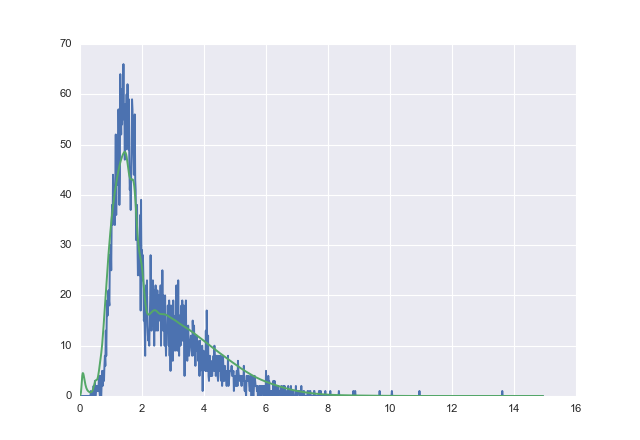

In [47]:
plt.figure()
plt.plot(rmf.e_min, d.counts)
plt.plot(rmf.e_min, model_counts)

Let's set the model parameters to the fit results from XSPEC:

<IPython.core.display.Javascript object>


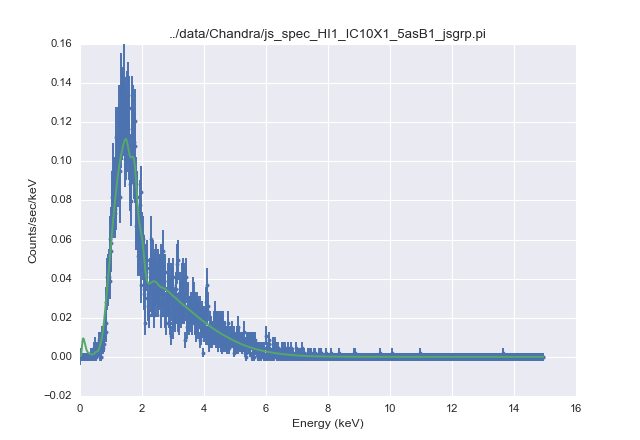

In [49]:
m._set_thawed_pars([0.313999, 1.14635, 0.0780871])
model_counts = d.eval_model(m)

plt.figure()
plt.plot(rmf.e_min, d.counts)
plt.plot(rmf.e_min, model_counts, lw=3)

## MCMC by hand

Just for fun, we're going to use `emcee` directly to sample from this model.

Let's first define a posterior object:

In [161]:
from scipy.special import gamma as scipy_gamma
from scipy.special import gammaln as scipy_gammaln

logmin = -100000000.0

class PoissonPosterior(object):
    
    def __init__(self, d, m):
        self.data = d
        self.model = m
        return
    
    def loglikelihood(self, pars, neg=False):
        
        self.model._set_thawed_pars(pars)
        mean_model = d.eval_model(self.model)
        
        #stupid hack to make it not go -infinity
        mean_model += np.exp(-20.)
        res = np.nansum(-mean_model + self.data.counts*np.log(mean_model) \
                - scipy_gammaln(self.data.counts + 1.))
            
        if not np.isfinite(res):
            res = logmin

        if neg:
            return -res
        else:
            return res

    def logprior(self, pars):
        
        nh = pars[0]
        p_nh = ((nh > 0.0) & (nh < 10.0))
        
        tin = pars[1]
        p_tin = ((tin > 0.0) & (tin < 5.0))
        
        lognorm = np.log(pars[2])
        p_norm = ((lognorm > -10.0) & (lognorm < 10.0))
        
        logp = np.log(p_nh*p_tin*p_norm)
        
        if not np.isfinite(logp):
            return logmin
        else:
            return logp
        
    def logposterior(self, pars, neg=False):
        lpost = self.loglikelihood(pars) + self.logprior(pars)

        if neg is True:
            return -lpost
        else:
            return lpost
        
    def __call__(self, pars, neg=False):
        return self.logposterior(pars, neg)

Now we can define a posterior object with the data and model objects:

In [162]:
lpost = PoissonPosterior(d, m)

Can we compute the posterior probability of some parameters?

In [163]:
print(lpost([0.1, 0.1, 0.1]))
print(lpost([0.313999, 1.14635, 0.0780871]))

-102877.239611
-1215.64621715


The one below should fail, because it's outside the prior:

In [164]:
print(lpost([-0.1, 0.1, 0.1]))
print(lpost([0.1, -0.1, 0.1]))
print(lpost([0.1, 0.1, -0.1]))

-100102139.178
-100131331.357
-100131331.357


Okay, cool! This works.

Now we can run MCMC!

In [165]:
import emcee

In [191]:
start_pars = np.array([0.313999, 1.14635, 0.0780871])
start_cov = np.diag(start_pars/100.0)

In [192]:
nwalkers = 100
niter = 200
ndim = len(start_pars)
burnin = 50

In [193]:
p0 = np.array([np.random.multivariate_normal(start_pars, start_cov) for
               i in range(nwalkers)])


In [196]:
# initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost, args=[False], threads=4)


In [197]:
pos, prob, state = sampler.run_mcmc(p0, burnin)

In [200]:
_, _, _ = sampler.run_mcmc(pos, niter, rstate0=state)


<IPython.core.display.Javascript object>


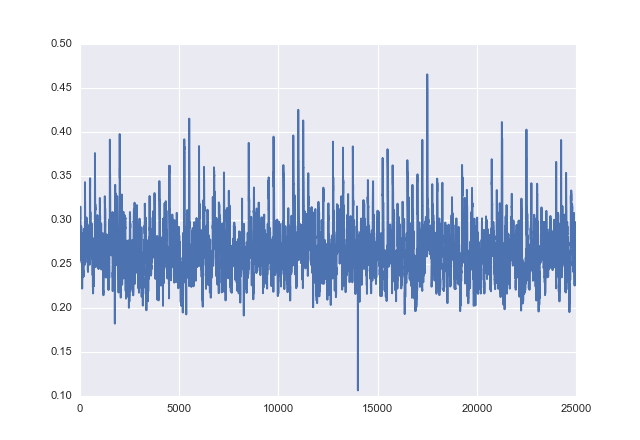

<IPython.core.display.Javascript object>


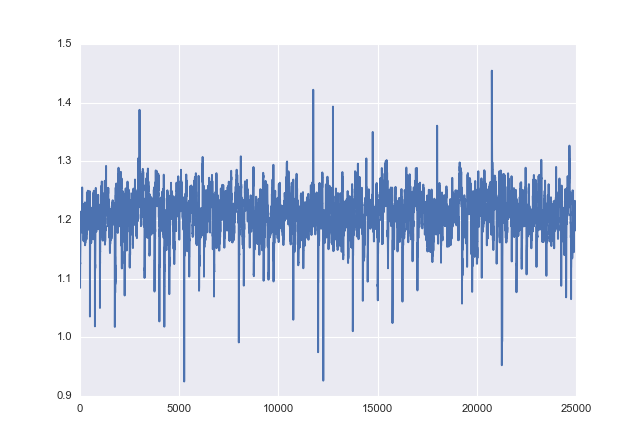

<IPython.core.display.Javascript object>


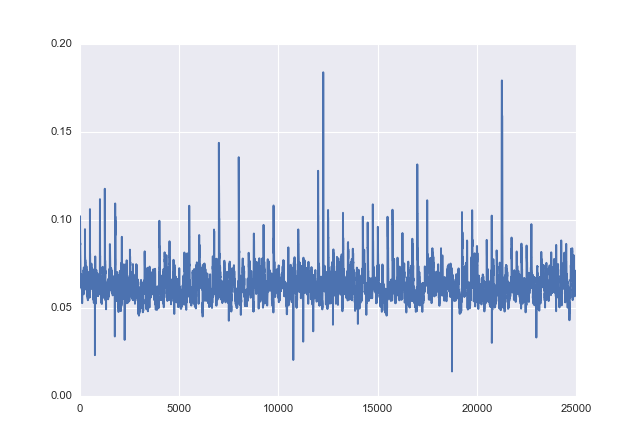

In [201]:
plt.figure()
plt.plot(sampler.flatchain[:,0])
plt.figure()
plt.plot(sampler.flatchain[:,1])
plt.figure()
plt.plot(sampler.flatchain[:,2])

In [203]:
import corner

(25000, 3)

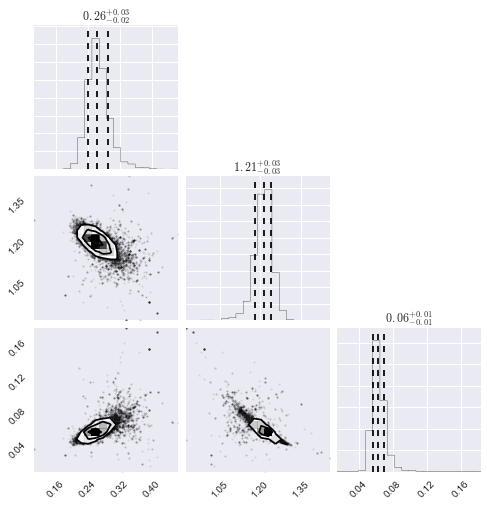

In [212]:
%matplotlib inline
corner.corner(sampler.flatchain,
              quantiles=[0.16, 0.5, 0.84],
              show_titles=True, title_args={"fontsize": 12});


## TO DO

* define my own user model
* figure out how to apply ARF/RMF directly to a set of counts